# RNN 的高级用法

这里介绍提高 RNN 的性能和泛化能力的 3 种高级技巧。

- **<font color='red'>循环 dropout (recurrent dropout)</font>**。在循环层中使用 dropout 来降低 overfitting。


- **<font color='red'>堆叠循环层 (stacking recurrent layers)</font>**。提高 NN 的表示能力 (代价是更高的 computational loads)。


- **<font color='red'>双向循环层(bidirectional recurrent layer)</font>**。将相同的信息以不同的方式呈现给 RNN，可以提高精度并缓解遗忘问题。

## 1. 定义问题

这里使用一个天气时间序列[数据集](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)。在这个数据集中，每 10 分钟记录 14 个不同的量 (如气温、气压、湿度、风向等)，其中包含多年的数据。原始数据可追溯到 2003 年，但本例仅使用 2009—2016 年的数据。

**这个数据集非常适合用来学习处理数值型时间序列。**

**用这个数据集来构建模型，输入最近的一些数据 (几天的数据点)，可以预测 24 小时之后的气温。**

In [1]:
# Common imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
tf.__version__

'2.1.0'

In [3]:
# Raw data
data_dir = '/home/libing/datasets/jena_climate'
data_path = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [4]:
!head -n 3 /home/libing/datasets/jena_climate/jena_climate_2009_2016.csv

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10


In [5]:
# Load the data
data = pd.read_csv(data_path)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


数据中共有 420551 条数据，每一行是一个 timestep，记录了一个日期和 14 与天气有关的值。

In [7]:
# Parse the data
float_data = data.values[:, 1:]
# 不然预处理时会出错
float_data = float_data.astype('float64')

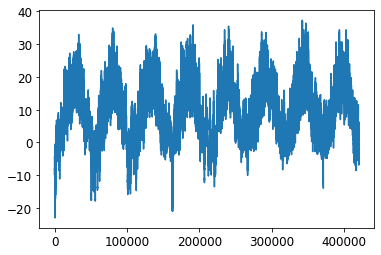

In [8]:
# 温度随时间的变化曲线
temp = float_data[:, 1]  # temperature
plt.plot(temp)
plt.show()

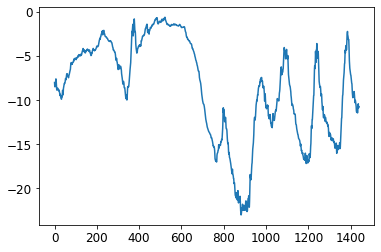

In [9]:
# 绘制前 10 天的温度时间序列
plt.plot(temp[:1440])
plt.show()

每 10 分钟记录一次，1 天 24x6=144 条数据，10 天 1440 条数据。

可以看到每天的周期性变化，尤其是最后 4 天特别明显。这 10 天一定是来自于很冷的冬季月份。

**如果想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。**但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？

**<font color='blue'>问题：</font>** 一个时间步是 10 分钟，每 steps 个时间步采样一次数据，给定过去 lookback 个时间步内的数据，能否预测 delay 个时间步之后的温度？

- `lookup=720`：给定过去 5 天内的观测数据


- `steps=6`：观测数据的采样频率是每小时一个数据点


- `delay=144`：目标是未来 24 小时之后的数据

## 2. 准备数据

In [10]:
# 数据预处理——让特征在相似的范围内都取较小的特征
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

编写一个 Python 生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。

**因为数据集中的样本是高度冗余的 (对于第 N 个样本和 第 N+1 个样本，大部分时间步都是相同的)，所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本。**

In [11]:
def load_and_process_data(file_path=data_path):
    data = pd.read_csv(file_path)

    float_data = data.values[:, 1:]
    # 不然预处理时会出错
    float_data = float_data.astype('float64')

    # 数据预处理——让特征在相似的范围内都取较小的特征
    mean = float_data[:200000].mean(axis=0)
    float_data -= mean
    std = float_data[:200000].std(axis=0)
    float_data /= std

    return float_data

In [12]:
floa_data = load_and_process_data()

In [13]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
              batch_size=128, step=6):
    """生成一个元组 (samples, targets)。

    其中 samples 是输入数据的一个 batch，targets 是对应的目标温度数据。

    Parameters
    ----------
    data: np.array, 原始数据
    lookback: 输入数据应该包括过去多少个时间步
    delay: 目标应该在未来多少个时间步之后
    min_index 和 max_index: data 数组中的索引，用于界定需要抽取哪些时间步
    shuffle: 是否打乱数据。默认按顺序抽取数据
    batch_size: 每个 batch 的样本数
    step: 数据采样的周期/时间步。默认，每小时 (6 个时间步) 抽取一个数据点
    """
    # 确保在生成样本时，每个时间步之后都有 delay 个时间步数据，用于生成 target
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback  # 可以生成样本的起始时间步

    while True:
        if shuffle:  # 打乱数据，在范围内随机生成 batch_size 个时间步来生成样本
            rows = np.random.randint(i, max_index, size=batch_size)
            # rows = np.random.randint(min_index+lookback, max_index, size=batch_size)  # 原文代码
        else:
            # 如果超出 max_index，则从头开始
            # 为了可以一直生成数据，每次调用这个函数结果都是一样的
            if i + batch_size >= max_index:  # 神来之笔
                i = min_index + lookback
            # 生成 rows 数组，其范围从第 i 个时间步到第 i+batch_size 个时间步
            rows = np.arange(i, i+batch_size)
            # rows = np.arange(i, min(i+batch_size, max_index))  # 原文代码
            i += len(rows)

        # shape (batch_size, 采样数, 特征值)
        samples = np.zeros(shape=(len(rows),
                                  lookback // step,  # 每 step 采样一次数据
                                  data.shape[-1]))
        targets = np.zeros(shape=(len(rows), ))
        for j, row in enumerate(rows):
            # 在第 row 个时间步时，每隔 step 个时间步来采样过去 lookback 个时间步内的数据
            indices = range(row-lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row+delay][1]  # 第 row+delay 个时间步的温度作为 target
        # 因为这里使用的是 tensorflow 2.1 而且输出的是 generator
        # 第 3 个输出是 sample_weight
        # 如果没有第 3 个输出，在 fit 的时候会有一个 warning
        yield samples, targets, [None]

In [14]:
lookback = 1440   # 输入数据应该包括过去多少个时间步
step = 6          # 数据采样的周期/时间步。每小时 (6 个时间步) 抽取一个数据点
delay = 144       # 目标应该在未来多少个时间步之后
batch_size = 128  # 每个 batch 的样本数


train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 需要从 val_gen 生成多少次数据才能查看整个验证集
val_steps = (300000 - 200001 - lookback) // batch_size


# 为了查看整个测试集，需要从 test_gen 生成多少次数据
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 3. 基于常识的、非 ML 基准方法

在开始尝试 DL 模型之前，可以先尝试一种基于常识的简单方法。

<font color='crimson'>基于常识的基准方法可以作为合理性检查，还可以建立一个基准，更高级的 ML 模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。</font>

> 一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含 90% 的类别 A 实例和 10% 的类别 B 实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别 “A”。这种分类器的总体精度为 90%，因此任何基于学习的方法在精度高于 90% 时才能证明其有效性。

有时候，这样基本的基准方法可能很难打败。

这里，温度时间序列是连续的 (明天的温度很可能接近今天的温度)，并且具有每天的周期性变化。因此，<font color='crimson'>一种基于常识的方法就是始终预测 24 小时后的温度等于现在的温度。</font>

使用平均绝对误差 (MAE) 指标来评估这种方法。

In [15]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets, _ = next(val_gen)
        preds = samples[:, -1, 1]  # 现在的温度作为 24 小时之后的温度
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [16]:
evaluate_naive_method()

0.28973597299054815


In [17]:
# 将 MAE 转换为温度
0.29 * std[1]

2.567224733839344

因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为`0.29×temperature_std` 摄氏度，即 2.57°C。

## 4. 一种基本的 ML 方法

<font color='crimson'>开始研究复杂且计算代价很高的模型 (比如 RNN) 之前，尝试使用简单且计算代价低的 ML  模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。</font>

In [18]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='rmsprop',
              loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 1.7243 - val_loss: 0.7564
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.6686 - val_loss: 0.4249
Epoch 3/20
500/500 [==============================] - 19s 37ms/step - loss: 0.3427 - val_loss: 0.3273
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2777 - val_loss: 0.3333
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2599 - val_loss: 0.3116
Epoch 6/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2481 - val_loss: 0.3418
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2394 - val_loss: 0.3255
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2354 - val_loss: 0.3454
Epoch 9/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2314 - val_loss: 0.3307
Epoch 10/20
500/500 [=================

In [19]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=16)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.show()

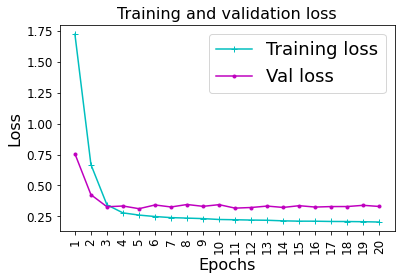

In [20]:
plt.figure(figsize=(6, 3.8))
plot_history(history)

部分验证损失接近不包含学习的基准方法。事实证明，超越这个基准并不容易。常识中包含了大量有价值的信息，而机器学习模型并不知道这些信息。

在模型空间 (即假设空间) 中搜索解决方案，这个模型空间是具有我们所定义的架构的所有两层网络组成的空间。如果你在一个复杂模型的空间中寻找解决方案，那么可能无法学到简单且性能良好的基准方法。<font color='crimson'>如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到简单问题的简单解决方案的。</font>

## 5. 第一个 RNN 基准

**<font color='blue'>`Flatten` 将时间序列展平，这从输入数据中删除了时间的概念。</font>**

<font color='crimson'>原始数据是一个序列，其中因果关系和顺序都很重要。</font>

<font color='crimson'>门控循环单元 (GRU，gated recurrent unit) 层的工作原理与 LSTM 相同。但它做了一些简化，因此运行的计算代价更低 (虽然表示能力可能不如 LSTM)。</font>

In [21]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 115s 230ms/step - loss: 0.2980 - val_loss: 0.2691
Epoch 2/20
500/500 [==============================] - 118s 237ms/step - loss: 0.2844 - val_loss: 0.2673
Epoch 3/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2777 - val_loss: 0.2661
Epoch 4/20
500/500 [==============================] - 114s 227ms/step - loss: 0.2733 - val_loss: 0.2638
Epoch 5/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2703 - val_loss: 0.2637
Epoch 6/20
500/500 [==============================] - 115s 230ms/step - loss: 0.2688 - val_loss: 0.2627
Epoch 7/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2646 - val_loss: 0.2643
Epoch 8/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2611 - val_loss: 0.2678
Epoch 9/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2574 - val_loss: 0.2642
Epoch 10/20
500/500 

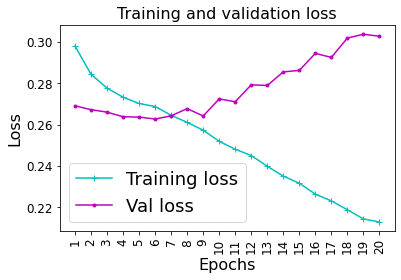

In [22]:
plt.figure(figsize=(6, 3.8))
plot_history(history)

这个模型比基于常识的基准模型好。

这个模型结果也证明了，在这种任务上，RNN 比序列展平的密集连接网络有优势。

这个结果确实有所提高，但可能仍有改进的空间。

## 6. 使用循环 dropout 来降低 overfitting

从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。

<div class="alert alert-block alert-info">
     <b><center>在循环网络中使用 dropout 的正确方法</center></b><br>
     对每个时间步应该使用相同的 dropout mask (相同模式的舍弃单元)，而不是让 dropout mask 随着时间步的增加而随机变化。此外，为了对 GRU、LSTM 等循环层得到的表示做正则化，应该将不随时间变化的 dropout mask 应用于层的内部循环激活 (叫作循环 dropout mask)。对每个时间步使用相同的 dropout mask，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的 dropout mask 则会破坏这个误差信号，并且不利于学习过程。
</div>

**<font color='crimson'>Keras 的每个循环层都有 2 个与 dropout 有关的参数：</font>**

- **`dropout`**，指定该层输入单元的 dropout 比率


- **`recurrent_dropout`**，指定循环单元的 dropout 比率

**<font color='crimson'>因为使用 dropout 正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的 2 倍。</font>**

In [23]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(layers.GRU(32,
                      # Fraction of the units to drop for the linear transformation of the inputs
                      dropout=0.2,
                      # Fraction of the units to drop for the linear transformation of the recurrent state
                      recurrent_dropout=0.2,
                      input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    # 使用了 dropout，需要更长的时间才能完全收敛
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 141s 281ms/step - loss: 0.3346 - val_loss: 0.2821
Epoch 2/40
500/500 [==============================] - 147s 293ms/step - loss: 0.3134 - val_loss: 0.2713
Epoch 3/40
500/500 [==============================] - 142s 284ms/step - loss: 0.3047 - val_loss: 0.2685
Epoch 4/40
500/500 [==============================] - 140s 281ms/step - loss: 0.2995 - val_loss: 0.2669
Epoch 5/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2971 - val_loss: 0.2666
Epoch 6/40
500/500 [==============================] - 144s 287ms/step - loss: 0.2952 - val_loss: 0.2680
Epoch 7/40
500/500 [==============================] - 144s 289ms/step - loss: 0.2928 - val_loss: 0.2669
Epoch 8/40
500/500 [==============================] - 145s 291ms/step - loss: 0.2914 - val_loss: 0.2667
Epoch 9/40
500/500 [==============================] - 141s 281ms/step - loss: 0.2887 - val_loss: 0.2625
Epoch 10/40
500/500 

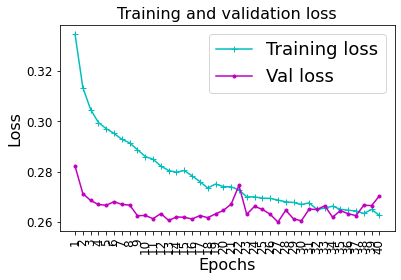

In [24]:
plt.figure(figsize=(6, 3.8))
plot_history(history)

## 7. 堆叠循环层 (Stacked RNN)

模型不再过拟合，但似乎遇到了性能瓶颈，所以应该考虑增加网络容量。

ML 的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍 (假设已经采取基本步骤来降低过拟合，比如使用 dropout)。只要过拟合不是太严重，那么很可能是容量不足的问题。

<font color='crimson'>增加网络容量的通常做法是增加每层单元数或增加层数。</font>

<font color='crimson'>逐个堆叠 RNN 时，所有中间层都应该返回完整的输出序列 (一个 3D 张量)，而不是只返回最后一个时间步的输出。</font>

In [25]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(layers.GRU(32,
                      # Fraction of the units to drop for the linear transformation of the inputs
                      dropout=0.1,
                      # Fraction of the units to drop for the linear transformation of the recurrent state
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    # 使用了 dropout，需要更长的时间才能完全收敛
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 287s 574ms/step - loss: 0.3367 - val_loss: 0.2789
Epoch 2/40
500/500 [==============================] - 284s 567ms/step - loss: 0.3130 - val_loss: 0.2767
Epoch 3/40
500/500 [==============================] - 288s 576ms/step - loss: 0.3072 - val_loss: 0.2715
Epoch 4/40
500/500 [==============================] - 275s 551ms/step - loss: 0.3017 - val_loss: 0.2752
Epoch 5/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2985 - val_loss: 0.2705
Epoch 6/40
500/500 [==============================] - 284s 568ms/step - loss: 0.2949 - val_loss: 0.2661
Epoch 7/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2911 - val_loss: 0.2660
Epoch 8/40
500/500 [==============================] - 274s 548ms/step - loss: 0.2892 - val_loss: 0.2647
Epoch 9/40
500/500 [==============================] - 287s 573ms/step - loss: 0.2860 - val_loss: 0.2704
Epoch 10/40
500/500 

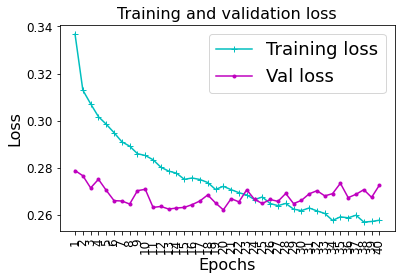

In [26]:
plt.figure(figsize=(6, 3.8))
plot_history(history)

可以看到 overfitting 仍然不是很严重，所以仍可以增大每层的大小，以进一步改进。

添加一层后模型并没有显著改进，所以提高网路能力的回报在逐渐减小。

## 8. 使用双向 RNN 

双向 RNN (bidirectional RNN) 在某些任务上的性能比普通 RNN 更好。常用于 NLP ，可谓 DL 对 NLP 的瑞士军刀。

<font color='blue'>RNN 特别依赖于顺序或时间，RNN 按顺序处理输入序列的时间步，而打乱时间步或反转时间步会完全改变 RNN 从序列中提取的表示。正是由于这个原因，如果顺序对问题很重要 (比如温度预测问题)，RNN 的表现会很好。</font>

**<font color='crimson'>双向 RNN 利用了 RNN 的顺序敏感性：它包含两个普通 RNN (LSTM/GRU)，每个 RNN 分别沿一个方向对输入序列进行处理 (时间正序和时间逆序)，然后将它们的表示合并在一起。通过沿这两个方向处理序列，双向 RNN 能够捕捉到可能被单向 RNN 忽略的模式。</font>**

In [29]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback  # 可以生成样本的起始时间步

    while True:
        if shuffle:  # 打乱数据，在范围内随机生成 batch_size 个时间步来生成样本
            rows = np.random.randint(i, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:  # 神来之笔
                i = min_index + lookback
            # 生成 rows 数组，其范围从第 i 个时间步到第 i+batch_size 个时间步
            rows = np.arange(i, i+batch_size)
            i += len(rows)

        # shape (batch_size, 采样数, 特征值)
        samples = np.zeros(shape=(len(rows),
                                  lookback // step,  # 每 step 采样一次数据
                                  data.shape[-1]))
        targets = np.zeros(shape=(len(rows), ))
        for j, row in enumerate(rows):
            # 在第 row 个时间步时，每隔 step 个时间步来采样过去 lookback 个时间步内的数据
            indices = range(row-lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row+delay][1]  # 第 row+delay 个时间步的温度作为 target
        # 因为这里使用的是 tensorflow 2.1 而且输出的是 generator
        # 第 3 个输出是 sample_weight
        # 如果没有第 3 个输出，在 fit 的时候会有一个 warning
        yield samples[:, ::-1, :], targets, [None]


train_gen_reverse = reverse_order_generator(float_data,
                                            lookback=lookback,
                                            delay=delay,
                                            min_index=0,
                                            max_index=200000,
                                            shuffle=True,
                                            step=step,
                                            batch_size=batch_size)
val_gen_reverse = reverse_order_generator(float_data,
                                  lookback=lookback,
                                  delay=delay,
                                  min_index=200001,
                                  max_index=300000,
                                  step=step,
                                  batch_size=batch_size)

In [30]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    layers.GRU(32, input_shape=(None, float_data.shape[-1])),
    layers.Dense(1)
])

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen_reverse,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen_reverse,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 118s 235ms/step - loss: 0.4810 - val_loss: 0.4802
Epoch 2/20
500/500 [==============================] - 118s 237ms/step - loss: 0.4409 - val_loss: 0.4641
Epoch 3/20
500/500 [==============================] - 116s 232ms/step - loss: 0.3959 - val_loss: 0.4288
Epoch 4/20
500/500 [==============================] - 115s 231ms/step - loss: 0.3518 - val_loss: 0.3971
Epoch 5/20
500/500 [==============================] - 107s 215ms/step - loss: 0.3294 - val_loss: 0.3815
Epoch 6/20
500/500 [==============================] - 113s 226ms/step - loss: 0.3133 - val_loss: 0.3705
Epoch 7/20
500/500 [==============================] - 120s 240ms/step - loss: 0.2984 - val_loss: 0.3831
Epoch 8/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2905 - val_loss: 0.3680
Epoch 9/20
500/500 [==============================] - 114s 228ms/step - loss: 0.2815 - val_loss: 0.3571
Epoch 10/20
500/500 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



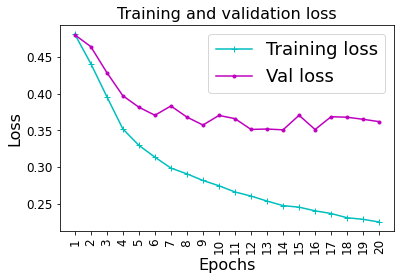

In [31]:
plt.figure(figsize=(6, 3.8))
plot_history(history)

逆序 GRU 的效果甚至比基于常识的基准方法还要差很多，这说明在本例中，按时间正序处理对成功解决问题很重要。这非常合理：<font color='crimson'>GRU 层通常更善于记住最近的数据，而不是久远的数据，与更早的数据点相比，更靠后的天气数据点对问题自然具有更高的预测能力</font> (这也是基于常识的基准方法非常强大的原因)。因此，按时间正序的模型必然会优于时间逆序的模型。

但对其他问题来说，情况可能并非如此。

由于在 `GRU` 中添加 `recurrent_dropout` 参数并在 GPU 中训练，loss 会爆炸，导致无法训练，因此，以上代码是在 CPU 上训练的。以下，代码使用了单块 GPU 来训练。

In [1]:
# Common imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(14, 4.2))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'c+-', label='Training acc')
    plt.plot(epochs, val_acc, 'm.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

In [2]:
# 在 IMDB 上训练一个 LSTM 模型
max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=max_features)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 128),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 20s 977us/sample - loss: 0.4532 - acc: 0.7958 - val_loss: 0.3662 - val_acc: 0.8476
Epoch 2/10
20000/20000 [==============================] - 14s 689us/sample - loss: 0.2818 - acc: 0.8905 - val_loss: 0.3116 - val_acc: 0.8762
Epoch 3/10
20000/20000 [==============================] - 14s 678us/sample - loss: 0.2229 - acc: 0.9172 - val_loss: 0.3884 - val_acc: 0.8330
Epoch 4/10
20000/20000 [==============================] - 13s 639us/sample - loss: 0.1965 - acc: 0.9293 - val_loss: 0.3189 - val_acc: 0.8762
Epoch 5/10
20000/20000 [==============================] - 13s 643us/sample - loss: 0.1697 - acc: 0.9396 - val_loss: 0.3012 - val_acc: 0.8830
Epoch 6/10
20000/20000 [==============================] - 12s 615us/sample - loss: 0.1485 - acc: 0.9477 - val_loss: 0.3287 - val_acc: 0.8600
Epoch 7/10
20000/20000 [==============================] - 12s 623us/sample - loss: 0.1317 - acc: 0.9531 -

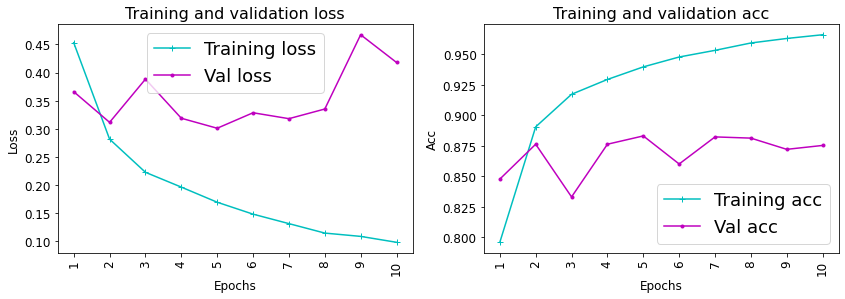

In [4]:
plot_history(history)

In [5]:
# 将 IMDB 中每条数据逆序后来训练一个 LSTM 模型
max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=max_features)
# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 128),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 16s 789us/sample - loss: 0.5009 - acc: 0.7555 - val_loss: 0.4441 - val_acc: 0.8100
Epoch 2/10
20000/20000 [==============================] - 12s 624us/sample - loss: 0.3105 - acc: 0.8796 - val_loss: 0.3163 - val_acc: 0.8700
Epoch 3/10
20000/20000 [==============================] - 12s 615us/sample - loss: 0.2481 - acc: 0.9068 - val_loss: 0.5043 - val_acc: 0.8112
Epoch 4/10
20000/20000 [==============================] - 12s 620us/sample - loss: 0.2129 - acc: 0.9233 - val_loss: 0.3191 - val_acc: 0.8740
Epoch 5/10
20000/20000 [==============================] - 12s 622us/sample - loss: 0.1917 - acc: 0.9316 - val_loss: 0.3600 - val_acc: 0.8736
Epoch 6/10
20000/20000 [==============================] - 13s 628us/sample - loss: 0.1643 - acc: 0.9435 - val_loss: 0.3808 - val_acc: 0.8738
Epoch 7/10
20000/20000 [==============================] - 13s 667us/sample - loss: 0.1467 - acc: 0.9494 -

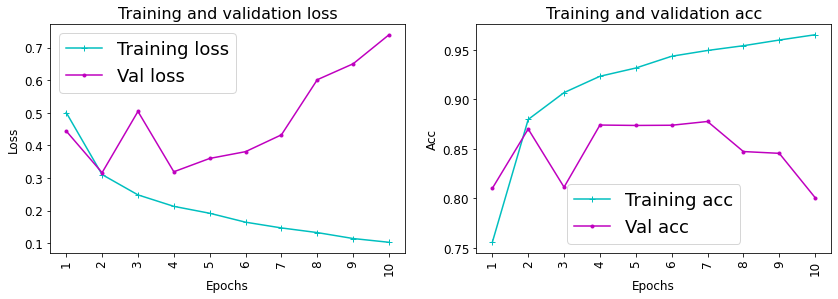

In [6]:
plot_history(history)

逆序与正序效果基本差不多。

在这样一个文本数据集上，逆序处理的效果与正序处理一样好，这证实了一个假设：<font color='crimson'>虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。重要的是，在逆序序列上训练的 RNN 学到的表示不同于在原始序列上学到的表示。</font>

**<font color='blue'>在机器学习中，如果一种数据表示不同但有用，那么总是值得加以利用，这种表示与其他表示的差异越大越好，它们提供了查看数据的全新角度，抓住了数据中被其他方法忽略的内容，因此可以提高模型在某个任务上的性能。这是集成的思想。</font>**

<font color='crimson'>双向 RNN 正是利用这个想法来提高正序 RNN 的性能。它从两个方向查看数据， 从而得到更加丰富的表示，并捕捉到仅使用正序 RNN 时可能忽略的一些模式。</font>

![bi-rnn](figs/chap06-figs/bi_rnn.png)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 128),
    tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(32, dropout=0.2),
        # 'sum', 'mul', 'concat' (Default), 'ave', None
        merge_mode='concat'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.5149 - acc: 0.7430 - val_loss: 0.3933 - val_acc: 0.8460
Epoch 2/10
20000/20000 [==============================] - 17s 868us/sample - loss: 0.3223 - acc: 0.8737 - val_loss: 0.3202 - val_acc: 0.8678
Epoch 3/10
20000/20000 [==============================] - 17s 862us/sample - loss: 0.2617 - acc: 0.9022 - val_loss: 0.4924 - val_acc: 0.7908
Epoch 4/10
20000/20000 [==============================] - 18s 875us/sample - loss: 0.2308 - acc: 0.9148 - val_loss: 0.3288 - val_acc: 0.8664
Epoch 5/10
20000/20000 [==============================] - 18s 889us/sample - loss: 0.2048 - acc: 0.9276 - val_loss: 0.3464 - val_acc: 0.8592
Epoch 6/10
20000/20000 [==============================] - 17s 867us/sample - loss: 0.1832 - acc: 0.9329 - val_loss: 0.3594 - val_acc: 0.8762
Epoch 7/10
20000/20000 [==============================] - 17s 842us/sample - loss: 0.1688 - acc: 0.9391 - v

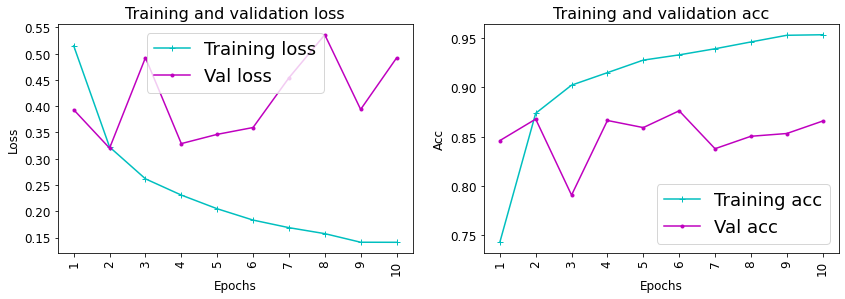

In [9]:
plot_history(history)

这里加了 dropout，所以结果和书中结果有所不同。知道思想就 OK 啦。

在温度预测问题上使用 Bi-RNN 的表现与普通 GRU 层差不多一样好。其原因很容易理解:所有的预测能力肯定都来自于正序的那一半网络，因为经知道逆序的那一半在这个任务上的表现非常糟糕 (本例同样是因为，最近的数据比久远的数据更加重要)。

这里不再给出代码了，因为太慢了。

**<font color='blue'>深度学习是一门艺术而不是科学。可以提供指导，对于给定问题哪些方法可能有用、哪些方法可能没用，但归根结底，每个问题都是独一无二的，必须根据经验对不同的策略进行评估。目前没有任何理论能够提前准确地告诉你，应该怎么做才能最优地解决问题。必须不断迭代。</font>**

**<font color='crimson'>Summary</font>**

- <font color='crimson'>遇到新问题时，最好首先为选择的指标建立一个基于常识的基准。如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步。</font>


- <font color='crimson'>在尝试计算代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有意义的。有时简单模型可能就是最佳选择。</font>


- <font color='crimson'>如果时间顺序对数据很重要，那么 RNN 是一种很适合的方法，与那些先将时间数据展平的模型相比，其性能要更好。</font>


- <font color='crimson'>想要在 RNN 中使用 dropout，你应该使用一个不随时间变化的 dropout mask 与循环 dropout mask。</font>


- <font color='crimson'>与单个 RNN 层相比，堆叠 RNN 的表示能力更加强大。但它的计算代价也更高，因此不一定总是需要。虽然它在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用。</font>


- <font color='crimson'>双向 RNN 从两个方向查看一个序列，它对 NLP 问题非常有用。但如果在序列数据中最近的数据比序列开头包含更多的信息，那么这种方法的效果就不明显。</font>

- <font color='crimson'>不要想着去预测股票价格！如果在数据集中过去能够很好地预测未来，那么机器 学习非常适合用于这种数据集。</font>

<font color='blue'>循环注意 (recurrent attention) 和序列掩码 (sequence masking) 通常对 NLP 特别有用，这里没有介绍。</font>